# NBD | Data Center

## Challenge #2 → *workload balancing*

Group composition:

- Gian Alvin Guico : 2033024
- Leonardo Di Nino : 1919479
- Luca Mazzucco : 1997610

Final report [here](https://nbviewer.org/github/LM1997610/Networking-for-Big-Data/blob/main/NBD_CH2_Report.pdf)

In [1]:
%%capture
!pip install tabulate

import numpy as np
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate

from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv('Cell_a.zip')

data = data[data['CPU']!=0]
data['Arrival_Time'] = data['Arrival_Time']/1e6
data['Arrival_Time'] = data['Arrival_Time'] - data['Arrival_Time'].iloc[0] 

print("\ndata.shape: {}\n".format(data.shape))
display(data.head())


data.shape: (2282872, 5)



,Job_ID,Task_ID,Arrival_Time,CPU,Memory
0,375000667413,0,0.000000,0.041851,0.001169
1,375000669289,0,3.386741,0.024968,0.001179
2,375000670586,0,5.968153,0.024176,0.001173
3,375000670588,0,5.968166,0.019552,0.001163
4,375000670590,0,6.016603,0.028044,0.001179


In [4]:
# Constrains

N = 64
µ = 0.1

--------------------------------------

### Explorative data analysis

In [5]:
data['CPU'].describe()

count    2.282872e+06
mean     4.042883e+00
std      1.370927e+02
min      9.536743e-07
25%      2.730942e-02
50%      7.698393e-02
75%      2.746394e-01
max      5.278707e+04
Name: CPU, dtype: float64

Assuming an underlying bounded Pareto process for the task size, we wanted to estimate a maximum likelihood estimator for the value of 𝛼 through a repeated subsampling.

In [6]:
%%capture
pip install distfit

In [7]:
from distfit import distfit

In [8]:
alpha = []
M = 1000
S = 1000
dist = distfit(distr='genpareto')
cpu = np.array(data['CPU'])

for i in tqdm(range(M)):
    subsample = cpu[np.random.randint(0,len(cpu),size=S)]
    alpha.append(dist.fit_transform(subsample, verbose = 0)['model']['params'][0])
    
print("\n alpha mean: ", np.mean(alpha))

100%|██████████| 1000/1000 [01:43<00:00,  9.66it/s]


 alpha mean:  1.195256476921913


Retrieving some statistics

In [9]:
global_var = data['CPU'].var()

min_load = data['CPU'].min()
max_load = data['CPU'].max()

ranging = (min_load, round(max_load,3))

In [10]:
count = data.groupby('Job_ID')["Task_ID"].count()
data2 = data.merge(count, on='Job_ID')

max_multi = data2[data2['Task_ID_y']!=0]['CPU'].max()
min_multi = data2[data2['Task_ID_y']!=0]['CPU'].min()
inner_multi_var = data2[data2['Task_ID_y']!=0]['CPU'].var()

max_single = data2[data2['Task_ID_y']==1]['CPU'].max()
min_single = data2[data2['Task_ID_y']==1]['CPU'].min()
inner_single_var = data2[data2['Task_ID_y']==1]['CPU'].var()

In [11]:
a_N = pd.unique(data2['Job_ID']).shape[0]

one_task = data2[data2['Task_ID_y']==1].shape[0]
multi_task = data2[data2['Task_ID_y']>1].shape[0]

stat = pd.Series({
    'Global variance': round(global_var,3),
    'Range':list(ranging),
    'Fraction of single-task-jobs': round(one_task/a_N,3),
    'Fraction of multi-task-jobs': round(1-one_task/a_N,3), 
    'Single-task max': round(max_single,3),
    'Single-task min': min_single,
    'Inner variance in single-task group': round(inner_single_var,3),
    'Multi-task job max': round(max_multi,3),
    'Multi-task job min': min_multi,
    'Inner variance in multi-task group': round(inner_multi_var,3)})

print()
print(tabulate(stat.to_frame(), tablefmt="fancy_grid", numalign='center', stralign="center"))


╒═════════════════════════════════════╤══════════════════════════════════╕
│           Global variance           │            18794.413             │
├─────────────────────────────────────┼──────────────────────────────────┤
│                Range                │ [9.5367431640625e-07, 52787.072] │
├─────────────────────────────────────┼──────────────────────────────────┤
│    Fraction of single-task-jobs     │              0.948               │
├─────────────────────────────────────┼──────────────────────────────────┤
│     Fraction of multi-task-jobs     │              0.052               │
├─────────────────────────────────────┼──────────────────────────────────┤
│           Single-task max           │            52787.072             │
├─────────────────────────────────────┼──────────────────────────────────┤
│           Single-task min           │       9.5367431640625e-07        │
├─────────────────────────────────────┼──────────────────────────────────┤
│ Inner variance in sing

In [12]:
jobs = pd.unique(data['Job_ID'])
temp = {job:k for (job,k) in zip(jobs, count)}

multitask = [job for job in jobs if temp[job]>1]

In [13]:
new_stat = pd.Series({
    'Variance of total CPU required':inner_multi_var,
    'Max value for total CPU required':max_multi,
    'Min value for total CPU required':min_multi})

## Baseline implementation: 
**Least_Work_Left**  for dispatching and **First_Come_First_Service** for scheduling:

<br>


In [14]:
from Dispatcher_LWL import Dispatcher

In [15]:
baseline = Dispatcher(N, data["Arrival_Time"].iloc[0])
baseline.print_status()


 Dispatcher → Least_Work_Left

 number of servers: 64 → First_Come_First_Service 

	 status: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ...] 

	 wk_load: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ...] 

	 memory: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ...] 

	 queue: [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] ...



In [16]:
for i in tqdm(range(data.shape[0])):
    
    task = data.iloc[i].to_dict()
    
    baseline.queue_manager(task)
    baseline.Least_Work_Left(task)
    baseline.clock_update(task['Arrival_Time'])
    
baseline_df = baseline.Closing()

100%|██████████| 2282872/2282872 [11:06<00:00, 3425.58it/s]



 Closing 2 active server queues: [0, 1] → 2 tasks...  done ✓ 



In [17]:
arrival_times = data.groupby('Job_ID')['Arrival_Time'].min()
base_completion_times = baseline_df.groupby('Job')['Completion_Time'].max()

base_job_response_times = np.array(base_completion_times)-np.array(arrival_times)
base_mean_job = round(np.mean(base_job_response_times), 3)

tot_cpu = data.groupby('Job_ID')['CPU'].sum() / µ
base_slow_down = base_job_response_times/np.array(tot_cpu)
base_mean_slow = round(np.mean(base_slow_down), 3)

ut_coeffs = [sum(baseline.servers[i].details)/baseline.clock for i in range(N)]

print("\nBaseline :")
print(" Mean job_response_time:", base_mean_job)
print(" Mean job_slow_down:", base_mean_slow)


Baseline :
 Mean job_response_time: 27470.201
 Mean job_slow_down: 1203727.169


----------------------------------------------

## Custom design: 
**Size-Interval Task Assignment-E (and LWL)** for dispatching and **First_Come_First_Service** for scheduling:

<br>


In [18]:
X = data['CPU'].sort_values()

quantum = sum(X)/64  # fill-up value for each chunk

print(quantum)

144209.119797647


In [19]:
ls, cumsum, cluster = [], 0, 0

for value in tqdm(X):
    if cumsum + value <= int(quantum):
        cumsum += value
    else:
        cumsum = 0
        cluster+=1
    
    ls.append(cluster)

sorted_df = data.sort_values('CPU')
sorted_df['cumsum'] = ls
data = sorted_df.sort_values('Job_ID')

100%|██████████| 2282872/2282872 [00:01<00:00, 1751867.11it/s]


In [20]:
#data.groupby("cumsum")["CPU"].sum().plot(kind="bar", alpha=0.75, rot=0);

--------------------------------------------

In [21]:
from Dispatcher_SITA import Size_Int_Task_Ass

In [22]:
costum =  Size_Int_Task_Ass(N, data["Arrival_Time"].iloc[0])
costum.print_status()


 Dispatcher → Size_Int_Task_Ass

 number of servers: 64 → First_Come_First_Service 

	 status: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ...] 

	 wk_load: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ...] 

	 memory: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ...] 

	 queue: [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] ...



In [23]:
for i in tqdm(range(data.shape[0])):
    
    task = data.iloc[i].to_dict()
    
    costum.queue_manager(task)
    costum.SITA_dispatch(task)
    costum.clock_update(task['Arrival_Time'])
    
costum_df = costum.Closing()   ## → 2128 tasks...

100%|██████████| 2282872/2282872 [06:29<00:00, 5862.77it/s]



 Closing 12 active server queues: [0, 1, 5, 6, 10, 11, 12, 46, 49, 51, 60, 62] → 2128 tasks...  done ✓ 



In [24]:
#arrival_times = data.groupby('Job_ID')['Arrival_Time'].min()
costum_completion_times = costum_df.groupby('Job')['Completion_Time'].max()

costum_job_response_times = np.array(costum_completion_times )-np.array(arrival_times)
costum_mean_job = round(np.mean(costum_job_response_times), 3)

#tot_cpu = data.groupby('Job_ID')['CPU'].sum() / µ 
custum_slow_down = costum_job_response_times/np.array(tot_cpu)
custum_mean_slow = round(np.mean(custum_slow_down), 3)

c_ut_coeffs = [sum(costum.servers[i].details)/costum.clock for i in range(N)]

print("\nCostum :")
print(" Mean job_response_time:", costum_mean_job)
print(" Mean job_slow_down:", custum_mean_slow)


Costum :
 Mean job_response_time: 756.528
 Mean job_slow_down: 1614.606


## Results:

In [ ]:
from visualization import make_plots as mp

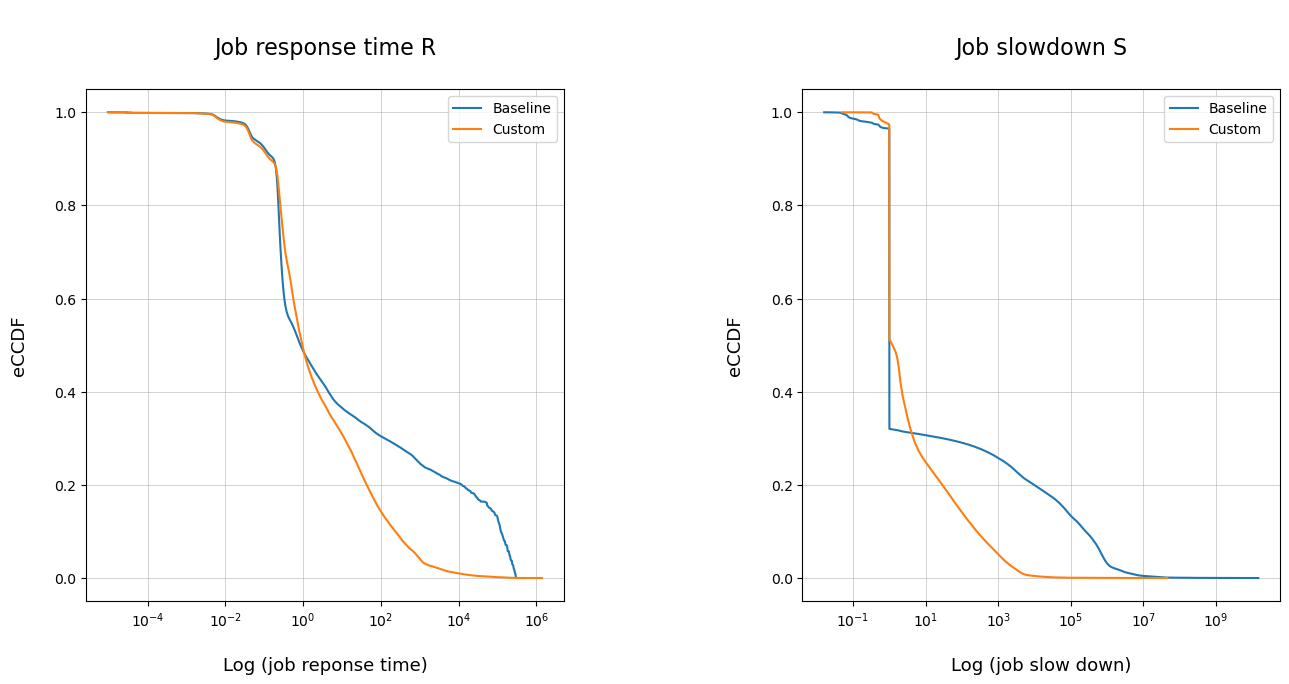

In [25]:
mp.ecdf_plot(base_job_response_times, 
             costum_job_response_times, 
             base_slow_down, custum_slow_down)

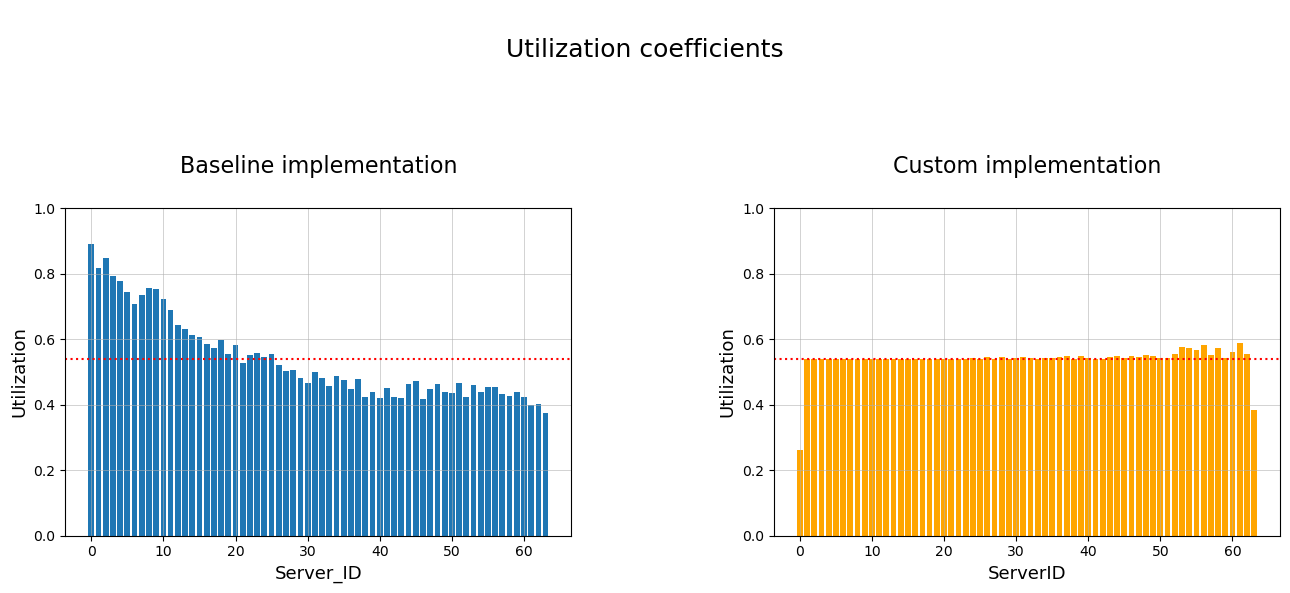

In [29]:
mp.coeff_plot(ut_coeffs, c_ut_coeffs)

In [27]:
base_m_load = 129
cust_m_load = (1752627*7 + data.shape[0]-1752627)/data.shape[0]

metrics = pd.DataFrame({
    'Mean Job_Response_Time': [base_mean_job, costum_mean_job],
    'Mean Job_Slow_Down': [base_mean_slow, custum_mean_slow],
    'Mean Utilization': [np.mean(ut_coeffs), np.mean(c_ut_coeffs)],
    'Mean Message_Load': [base_m_load, round(cust_m_load,3)]})

metrics.index = ['Baseline','Custom']

In [28]:
print()
print(tabulate(metrics, tablefmt="fancy_grid", headers= metrics.columns, numalign='center', stralign="center"))


╒══════════╤══════════════════════════╤══════════════════════╤════════════════════╤═════════════════════╕
│          │  Mean Job_Response_Time  │  Mean Job_Slow_Down  │  Mean Utilization  │  Mean Message_Load  │
╞══════════╪══════════════════════════╪══════════════════════╪════════════════════╪═════════════════════╡
│ Baseline │         27470.2          │     1.20373e+06      │      0.538425      │         129         │
├──────────┼──────────────────────────┼──────────────────────┼────────────────────┼─────────────────────┤
│  Custom  │         756.528          │       1614.61        │      0.538425      │        5.606        │
╘══════════╧══════════════════════════╧══════════════════════╧════════════════════╧═════════════════════╛


## Analysis and comments:

-  As we can see surely our analysis has been experimentally confirmed: the SITA-E with FCFS servers strongly improved time performances.\
   The right tail of the distributions in the custom case is very weaker.

- For what concerns utilization we didn’t achieved any improvement: this is due to the strong balancing we induced that sets every server on the same amount of work time-wise speaking. The sub-LWL we designed over server 0, 62 and 63 surely affects their utilization.

- Message load in the baseline case is a constant for all task, since 128 messages are needed to retrieve the least amount of work left (64 queries and 64 answers), plus 1 message to send the task; in the custom scenario we have to average between pure SITA where we only need 1 message and the sub-LWL where we need 7 messages for task (3 queries over server 0, 62 and 63, 3 answers and 1 task-message)

- 